In [ ]:
!apt update
!apt install -y openjdk-17-jdk-headless
!pip install pathling==7.2.0 deltalake==0.25.4 pandas==2.2.2 polars==1.26.0

In [2]:
from pathling import PathlingContext

pc = PathlingContext.create(
    enable_extensions=True,
    enable_delta=True,
    enable_terminology=False,
)

your 131072x1 screen size is bogus. expect trouble
25/06/03 10:49:43 WARN Utils: Your hostname, mik-233179-m resolves to a loopback address: 127.0.1.1; using 172.24.67.177 instead (on interface eth0)
25/06/03 10:49:43 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/home/jasmin/git/bzkf_graph_experiments/.venv/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/jasmin/.ivy2/cache
The jars for the packages stored in: /home/jasmin/.ivy2/jars
au.csiro.pathling#library-runtime added as a dependency
io.delta#delta-spark_2.12 added as a dependency
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-b13ee515-c932-4cac-a878-997eba63b19d;1.0
	confs: [default]
	found au.csiro.pathling#library-runtime;7.2.0 in central
	found io.delta#delta-spark_2.12;3.3.0 in central
	found io.delta#delta-storage;3.3.0 in central
	found org.antlr#antlr4-runtime;4.9.3 in central
	found org.apache.hadoop#hadoop-aws;3.3.4 in central
	found com.amazonaws#aws-java-sdk-bundle;1.12.262 in central
	found org.wildfly.openssl#wildfly-openssl;1.0.7.Final in central
:: resolution report :: resolve 528ms :: artifacts dl 36ms
	:: modules in use:
	au.csiro.pathling#library-runtime;7.2.0 from central in [default]
	com.amazonaws#aws-java-sdk-bundle;1.12.262 from central in [default]
	io.delt

In [ ]:
from pathling import Expression as exp

### Load Patient Data
# Wir laden die einzelnen FHIR-Bundles und generieren daraus je ein ndsjon-File pro Ressourcen-Typ

# !!Vorher müssen die json-Files in den Ordner data/ hier in die Laufzeit hochgeladen werden!!

data = pc.read.bundles(
    "./data", ["Patient", "Condition", "Observation", "Procedure"]
)

### Extract Patient Data

# Wir nutzen `reverseResolve`, um von der Patient-Resource auf die zugehörigen Diagnosen (`Condition`) zuzugreifen.

# Dabei extrahieren wir:
# - die Patienten-ID
# - das Geschlecht
# - das Geburtsdatum
# - den Diagnoseschlüssel (ICD 10)

result = data.extract(
    "Patient",
    columns=[
        exp("id", "patient_resource_id"),
        exp("identifier.value", "patid_pseudonym"),
        exp("gender", "gender"),
        exp("birthDate", "birth_date"),
        #exp("reverseResolve(Condition.subject).code.coding.where(system='http://fhir.de/CodeSystem/bfarm/icd-10-gm').code", "condition_code"),
    ],
)

result.show(2)

+-------------------+----------------+------+----------+
|patient_resource_id| patid_pseudonym|gender|birth_date|
+-------------------+----------------+------+----------+
|   60271b372396f53a|2f4017ec9a0d48c3|female|1954-06-30|
|   114b17715cd8962f|7a258cbfec3c558c|  male|1948-12-06|
+-------------------+----------------+------+----------+
only showing top 2 rows



25/06/03 15:51:30 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 130818 ms exceeds timeout 120000 ms
25/06/03 15:51:31 WARN SparkContext: Killing executors is not supported by current scheduler.
25/06/03 15:51:31 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at o

In [78]:
from pyspark.sql.functions import col

# Filtere beim Extrahieren nach bestimmten Diagnosen, z.B. C50 (Mammakarzinom):

mamma_patients = data.extract(
    "Patient",
    columns=[
        exp("id", "patient_id"),
        exp("birthDate", "birth_date"),
        exp("reverseResolve(Condition.subject).code.coding.where(system='http://fhir.de/CodeSystem/bfarm/icd-10-gm').code", "condition_code"),
    ],
).filter(col("condition_code").contains("C50"))

mamma_patients.show(truncate=False)

+----------------------------------------------------------------+----------+--------------+
|patient_id                                                      |birth_date|condition_code|
+----------------------------------------------------------------+----------+--------------+
|9142ee3ff7990f826ada966f03da267e0fe662f73858158f5e868b772cd68730|1950-10-15|C50.4         |
|a02e16474896f1d528cac71f2c9b4c45ac3c9028e3a53fb414a1f7882991ee07|1950-05-01|C50.9         |
|a02e16474896f1d528cac71f2c9b4c45ac3c9028e3a53fb414a1f7882991ee07|1950-05-01|C50.9         |
|a02e16474896f1d528cac71f2c9b4c45ac3c9028e3a53fb414a1f7882991ee07|1950-05-01|C50.9         |
|a02e16474896f1d528cac71f2c9b4c45ac3c9028e3a53fb414a1f7882991ee07|1950-05-01|C50.9         |
|a02e16474896f1d528cac71f2c9b4c45ac3c9028e3a53fb414a1f7882991ee07|1950-05-01|C50.9         |
|a02e16474896f1d528cac71f2c9b4c45ac3c9028e3a53fb414a1f7882991ee07|1950-05-01|C50.9         |
|a02e16474896f1d528cac71f2c9b4c45ac3c9028e3a53fb414a1f7882991ee07|1950

In [79]:
# Schreibe alle geladenen FHIR-Ressourcen als Delta Lake-Dateien in das Verzeichnis './delta'.
# Dabei wird jede Resource (z. B. Patient, Condition, Observation) als eigene Delta-Tabelle gespeichert.

data.write.delta("./delta")

In [88]:
from deltalake import DeltaTable

# Lade die 'Condition'-Tabelle aus dem Delta-Verzeichnis und wandle sie in ein Pandas DataFrame um.

dt = DeltaTable("./delta/Condition.parquet")
df = dt.to_pandas()
df_simple = df.drop(columns=["_extension"])
df_simple[["id", "code", "subject"]]

,id,code,subject
0,17bc83a84fc6d9a7f9df24684aae287df117609026a237...,"{'id': None, 'coding': [{'id': None, 'system':...","{'id': None, 'reference': 'Patient/4a8639bbad9..."
1,257c056341e9015dfdd7d15cab0a7414b348796b2b0181...,"{'id': None, 'coding': [{'id': None, 'system':...","{'id': None, 'reference': 'Patient/9142ee3ff79..."
2,413358315002752adf6281447c5ef51bc9e87334ca2c34...,"{'id': None, 'coding': [{'id': None, 'system':...","{'id': None, 'reference': 'Patient/66eab990c3a..."
3,5236d8328066567b90c671091d739dc044ae00f4f9e73a...,"{'id': None, 'coding': [{'id': None, 'system':...","{'id': None, 'reference': 'Patient/a02e1647489..."
4,781b35a7a67a782459e38993bcfcebb068ac97e8bdf214...,"{'id': None, 'coding': [{'id': None, 'system':...","{'id': None, 'reference': 'Patient/b7590139fce..."
5,864086c778055cfdcf52915c303af7bfa4941ae6f56fb9...,"{'id': None, 'coding': [{'id': None, 'system':...","{'id': None, 'reference': 'Patient/23283daf4d6..."
6,9896edd80f6833ea17fbb2c5ad5ca42caa1d02f41baea8...,"{'id': None, 'coding': [{'id': None, 'system':...","{'id': None, 'reference': 'Patient/a02e1647489..."
7,9b5cabc4facc22d2681d7b63c3986487f3646a7ad8c10f...,"{'id': None, 'coding': [{'id': None, 'system':...","{'id': None, 'reference': 'Patient/5098a39800d..."
8,a31f38c3b6c0d35e6f228a50ba288b814250c774b8dc89...,"{'id': None, 'coding': [{'id': None, 'system':...","{'id': None, 'reference': 'Patient/b7590139fce..."
9,a9b49e6ae910db956adf674338ec65dff97a2d4c07c1f0...,"{'id': None, 'coding': [{'id': None, 'system':...","{'id': None, 'reference': 'Patient/a02e1647489..."


In [96]:
import polars as pl

# Konvertiere das Pandas DataFrame in ein Polars DataFrame

pl_df = pl.from_dataframe(df_simple)

# 'code' ist ein verschachteltes Feld mit mehreren Unterfeldern wie 'coding' und 'text'.
# Mit .unnest("code") werden diese Unterfelder auf der obersten Ebene des DataFrames "ausgepackt".

pl_df.select("code").unnest("code")

_fid,coding,id,text
i64,list[struct[7]],null,null
379779450,"[{1715992077,""C20"",null,null,""http://fhir.de/CodeSystem/bfarm/icd-10-gm"",null,""2020""}]",null,null
708753427,"[{1576562349,""C50.4"",null,null,""http://fhir.de/CodeSystem/bfarm/icd-10-gm"",null,""2020""}]",null,null
1706917596,"[{583564188,""C91.1"",null,null,""http://fhir.de/CodeSystem/bfarm/icd-10-gm"",null,""2020""}]",null,null
1642904422,"[{994824596,""C20"",null,null,""http://fhir.de/CodeSystem/bfarm/icd-10-gm"",null,""2020""}]",null,null
36927084,"[{386082870,""C91.1"",null,null,""http://fhir.de/CodeSystem/bfarm/icd-10-gm"",null,""2017""}]",null,null
…,…,…,…
143522712,"[{30510943,""D06.9"",null,null,""http://fhir.de/CodeSystem/bfarm/icd-10-gm"",null,""2022""}]",null,null
596728250,"[{1384451631,""D06.9"",null,null,""http://fhir.de/CodeSystem/bfarm/icd-10-gm"",null,""2022""}]",null,null
1660557819,"[{1396404776,""C56"",null,null,""http://fhir.de/CodeSystem/bfarm/icd-10-gm"",null,""2017""}]",null,null


+----------+----+
|birth_date|age |
+----------+----+
|1953-07-21|71  |
|1948-03-05|77  |
|1951-10-15|73  |
|1980-01-02|45  |
|1950-05-01|75  |
|1950-05-01|75  |
|1950-05-01|75  |
|1950-05-01|75  |
|1952-03-05|73  |
|1969-06-01|55  |
|NULL      |NULL|
|1950-10-15|74  |
|1951-01-07|74  |
|1960-01-16|65  |
|1980-01-01|45  |
+----------+----+



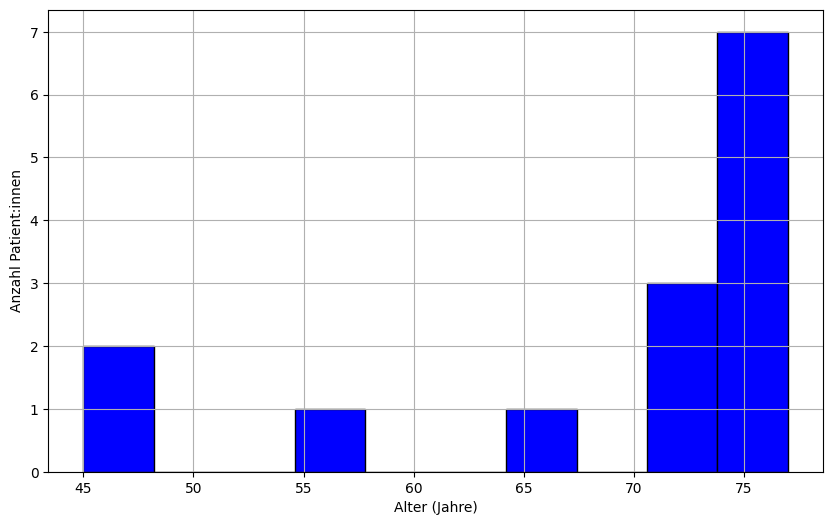

In [100]:
### AUFGABE 1 (Warm-Up): Altersverteilung der onkologischen Patient:innen


# 1.1 Extrahiere das Geburtsdatum aus den Daten der Patient:innen

patients = data.extract(
    "Patient",
    columns=[
        exp("birthDate", "birth_date"),
    ],
)

# 1.2 Berechne das Alter aus dem Geburtsdatum und füge es als neue Zeile in den DataFrame ein

from pyspark.sql.functions import col, current_date, datediff, floor, to_date

patients = patients.withColumn(
    "birth_date", to_date(col("birth_date"))
).withColumn(
    "age", floor(datediff(current_date(), col("birth_date")) / 365.25)
)

patients.select("birth_date", "age").show(truncate=False)

# 1.3 Daten in Pandas überführen

patients_pd = patients.toPandas()

# 1.4 Zeichne ein Histogramm der Altersverteilung

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(patients_pd["age"].dropna(), bins=10, edgecolor="black", color="blue")
plt.xlabel("Alter (Jahre)")
plt.ylabel("Anzahl Patient:innen")
plt.grid(True)
plt.show()
